<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "CA,DG"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/BrainStructures/CA,DG/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


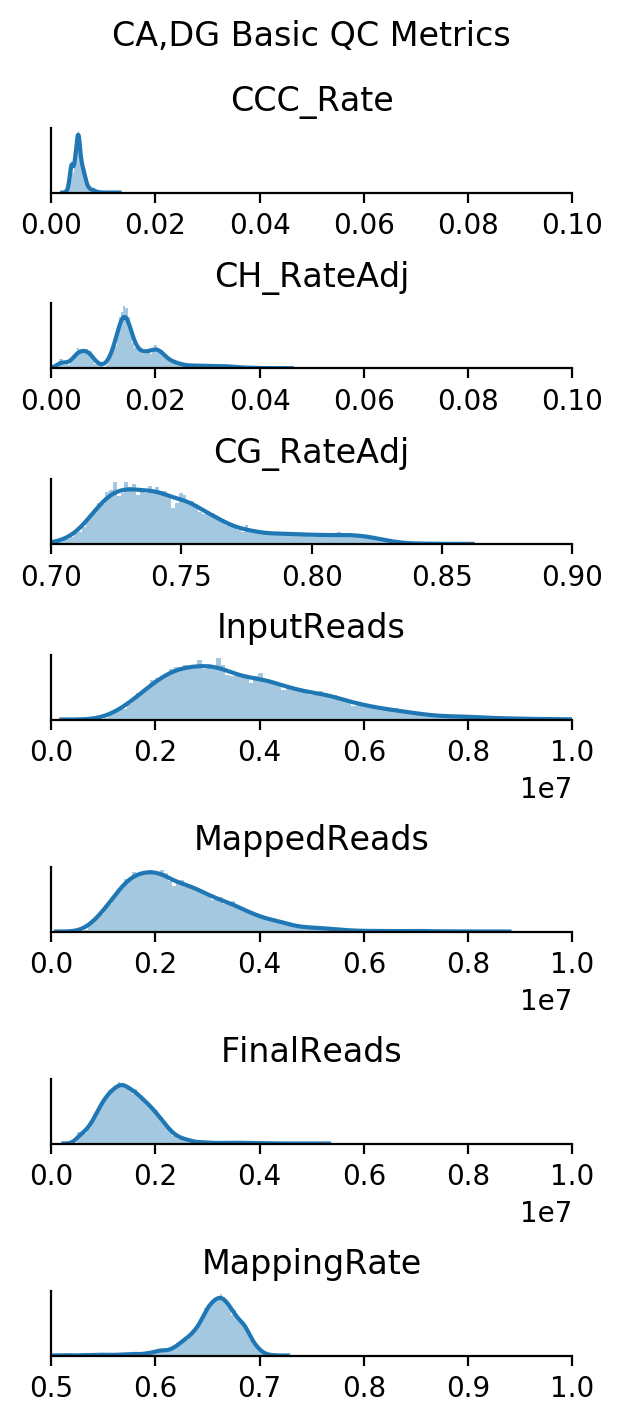

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

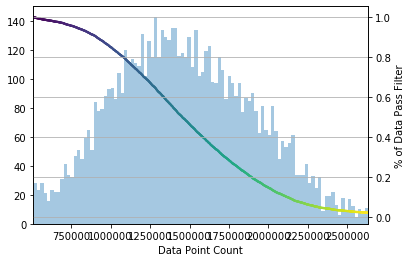

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 7140/7140 (100.0%)
CG_RateAdj passed 7140/7140 (100.0%)
CH_RateAdj passed 7140/7140 (100.0%)
FinalReads passed 7140/7140 (100.0%)
MappingRate passed 7140/7140 (100.0%)
Overall passed 7140/7140 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190212 1169
190214 1224
190219 1296
190305 1213
190625 884
190627 1354


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 893 232.6%
ad002 942 245.3%
ad004 942 245.3%
ad006 927 241.4%
ad007 848 220.8%
ad008 849 221.1%
ad010 865 225.3%
ad012 874 227.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
10E_M_0,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.008198,0.822633,0.821166,0.041640,0.033718,1626504.0,4407752,2892347.0,10E,...,-23.368460,-1.151200,-34.021153,-19.429447,MGE-Sst Rxra,-0.766630,-16.704815,20.297781,1.192093,True
10E_M_1,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006019,0.743035,0.741479,0.024127,0.018218,2009998.0,5524084,3657352.0,10E,...,-8.322600,-3.988057,19.205085,10.272570,CA3 Cadm2,4.290240,-2.610511,7.860870,8.813396,True
10E_M_10,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006569,0.750172,0.748520,0.027665,0.021235,1383636.0,3455260,2172987.0,10E,...,-7.409779,-4.662556,20.146606,6.345836,CA3 Cadm2,5.852028,-2.510058,12.927795,8.544050,True
10E_M_101,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006353,0.760898,0.759369,0.026547,0.020323,2474670.0,7245482,4778768.0,10E,...,-6.266342,-8.345406,25.465765,-6.767192,CA3 Cadm2,11.189178,-3.763147,29.875836,2.739283,True
10E_M_102,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005409,0.752980,0.751637,0.019497,0.014164,2430290.0,7004754,4609570.0,10E,...,-1.135772,-17.311239,-7.427455,-20.497435,CA1 Chrm3,2.912797,2.683262,-19.971042,24.551260,True
10E_M_103,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005817,0.734664,0.733111,0.021539,0.015813,2949180.0,8645474,5564327.0,10E,...,2.086893,-20.342037,-24.738968,2.250678,CA1 Chrm3,0.696956,-2.807185,-0.308627,-14.193012,True
10E_M_104,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006331,0.754637,0.753074,0.026948,0.020747,2035522.0,5881902,3881262.0,10E,...,-7.103261,-7.651474,26.687468,-2.719199,CA3 Cadm2,9.512602,-4.622000,24.992670,1.082815,True
10E_M_107,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006561,0.764111,0.762553,0.027432,0.021009,2201852.0,6371290,4227782.0,10E,...,-6.364866,-6.986124,23.252454,-2.001324,CA3 Cadm2,8.922994,-3.386901,23.325837,5.707433,True
10E_M_108,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005524,0.753200,0.751829,0.021438,0.016003,1014884.0,2343026,1492197.0,10E,...,0.836196,-7.765902,5.032626,-25.191453,CA3-St18 Tead1,-2.900707,4.525035,-3.323069,1.805112,True
10E_M_109,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005839,0.772664,0.771329,0.019089,0.013327,796516.0,1890630,1203975.0,10E,...,-30.295033,-11.153941,28.020417,-50.321330,Unc5c Unc5c,7.941026,-9.309111,6.227443,-0.606680,True
